In [24]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import vstack, csr_matrix
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import vstack, csr_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import make_scorer
from joblib import dump, load
import pandas as pd
from joblib import load
import numpy as np

In [25]:
data = pd.read_csv("final_data.csv")
data.columns

Index(['Year', 'Month', 'DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest',
       'DepDelay', 'DepTimeBlk', 'ArrDelay', 'ArrTimeBlk', 'Cancelled',
       'ActualElapsedTime', 'Distance', 'Origin_HourlyAltimeterSetting',
       'Origin_HourlyDewPointTemperature', 'Origin_HourlyDryBulbTemperature',
       'Origin_HourlyPrecipitation', 'Origin_HourlyRelativeHumidity',
       'Origin_HourlySeaLevelPressure', 'Origin_HourlyVisibility',
       'Origin_HourlyWindDirection', 'Origin_HourlyWindGustSpeed',
       'Origin_HourlyWindSpeed', 'Dest_HourlyAltimeterSetting',
       'Dest_HourlyDewPointTemperature', 'Dest_HourlyDryBulbTemperature',
       'Dest_HourlyPrecipitation', 'Dest_HourlyRelativeHumidity',
       'Dest_HourlySeaLevelPressure', 'Dest_HourlyVisibility',
       'Dest_HourlyWindDirection', 'Dest_HourlyWindGustSpeed',
       'Dest_HourlyWindSpeed', 'Holiday'],
      dtype='object')

In [26]:
data['Year']=data['Year'].astype('category')
data['Month']=data['Month'].astype('category')
data['DayOfWeek']=data['DayOfWeek'].astype('category')
data['Operating_Airline ']=data['Operating_Airline '].astype('category')
data['Origin']=data['Origin'].astype('category')
data['Dest']=data['Dest'].astype('category')
data['DepTimeBlk'] = data['DepTimeBlk'].astype('category')
data['ArrTimeBlk'] = data['ArrTimeBlk'].astype('category')
data['Origin_HourlyWindDirection'] = data['Origin_HourlyWindDirection'].astype('category')
data['Dest_HourlyWindDirection'] = data['Dest_HourlyWindDirection'].astype('category')
data['Holiday'] = data['Holiday'].astype('category')
data['Cancelled'] = data['Cancelled'].astype('category')
data = data.drop(columns=['ActualElapsedTime'])

continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9700585 entries, 0 to 9700584
Data columns (total 33 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   Year                              category
 1   Month                             category
 2   DayOfWeek                         category
 3   Operating_Airline                 category
 4   Origin                            category
 5   Dest                              category
 6   DepDelay                          float64 
 7   DepTimeBlk                        category
 8   ArrDelay                          float64 
 9   ArrTimeBlk                        category
 10  Cancelled                         category
 11  Distance                          int64   
 12  Origin_HourlyAltimeterSetting     float64 
 13  Origin_HourlyDewPointTemperature  float64 
 14  Origin_HourlyDryBulbTemperature   float64 
 15  Origin_HourlyPrecipitation        float64 
 16  Origin_HourlyRelat

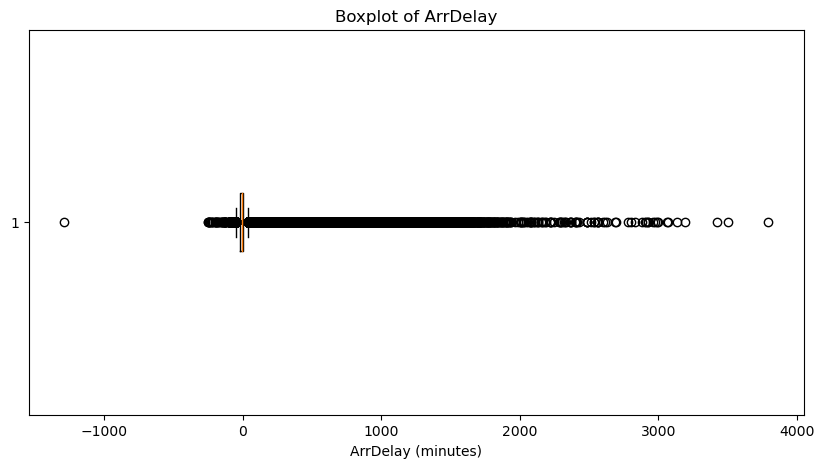

In [28]:
data = data[data['Cancelled'] != 1]

# 绘制箱线图
plt.figure(figsize=(10, 5))
plt.boxplot(data['ArrDelay'].dropna(), vert=False)
plt.title("Boxplot of ArrDelay")
plt.xlabel("ArrDelay (minutes)")
plt.show()

In [29]:
# Identify the minimum value in 'ArrDelay' (most negative delay) and remove that row as it's likely an anomaly
min_arr_delay = data['ArrDelay'].min()
data = data[data['ArrDelay'] != min_arr_delay]  # Remove row with minimum ArrDelay

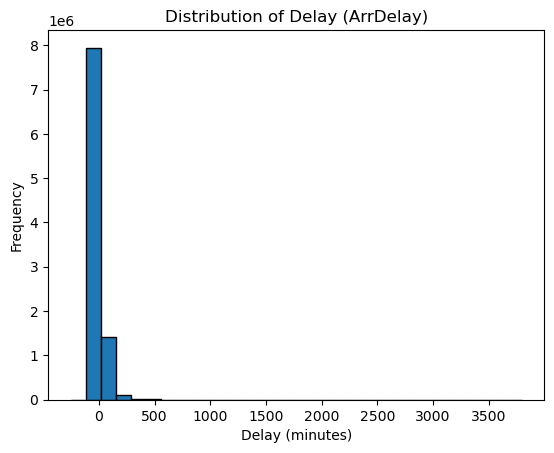

(0,
 count    9.509692e+06
 mean     3.196520e+00
 std      5.113526e+01
 min     -2.530000e+02
 25%     -1.600000e+01
 50%     -7.000000e+00
 75%      6.000000e+00
 max      3.795000e+03
 Name: ArrDelay, dtype: float64)

In [30]:
data = data.dropna(subset=['ArrDelay'])
# Check for NA values in the 'delay' column and calculate the distribution
delay_na_count = data['ArrDelay'].isna().sum()
delay_distribution = data['ArrDelay'].describe()

# Plot distribution of 'delay'
plt.hist(data['ArrDelay'].dropna(), bins=30, edgecolor='black')
plt.title("Distribution of Delay (ArrDelay)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.show()

(delay_na_count, delay_distribution)

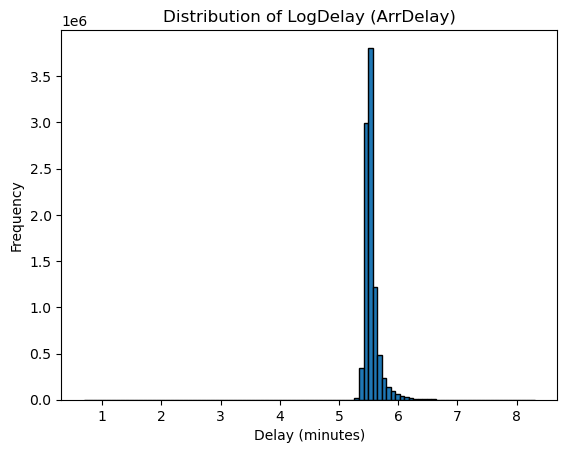

In [31]:
#log
min_delay = data["ArrDelay"].min() 
data['LogArrDelay'] = np.log1p(data["ArrDelay"] - min_delay +1)

plt.hist(data['LogArrDelay'].dropna(), bins=100, edgecolor='black')
plt.title("Distribution of LogDelay (ArrDelay)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.show()

In [32]:
# Define features and target variable
X = data.drop(columns=['Cancelled', 'DepDelay', 'ArrDelay','LogArrDelay'])
y = data['LogArrDelay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns and convert them to category type if needed
categorical_features = X.select_dtypes(include=['category']).columns.tolist()
# Convert categorical columns in the train and test sets to categorical dtype for LightGBM
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    
# Set up LightGBM dataset with categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features, reference=train_data)

In [31]:
#  Huber Loss 
def custom_huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error ** 2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss).mean()

def huber_loss(preds, train_data):
    d = preds - train_data.get_label()
    delta = 1.0  
    is_small_error = np.abs(d) <= delta
    squared_loss = 0.5 * d ** 2
    linear_loss = delta * (np.abs(d) - 0.5 * delta)
    return 'huber', np.where(is_small_error, squared_loss, linear_loss).mean(), False

huber_scorer = make_scorer(custom_huber_loss, greater_is_better=False)

params = {
    'learning_rate': 0.05,
    'max_depth': 10,
    'num_leaves': 50,
    'feature_fraction': 0.9,
    'bagging_fraction': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0,
    'n_estimators': 1000,
}

# 创建并训练模型
model = lgb.LGBMRegressor(
    **params,
    objective='regression',
    random_state=42
)

model.fit(X_train, y_train,eval_set = [(X_test,y_test)],
                 eval_metric=lambda y_true, y_pred: ('huber', custom_huber_loss(y_true, y_pred), False))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing col-wise

LGBMRegressor(bagging_fraction=1, feature_fraction=0.9, lambda_l1=0.1,
              lambda_l2=0, learning_rate=0.05, max_depth=10, n_estimators=1000,
              num_leaves=50, objective='regression', random_state=42)

In [32]:
# transform LogArrDelay to ArrDelay
y_train_log_pred = model.predict(X_train)
y_test_log_pred = model.predict(X_test)


y_train_pred = np.exp(y_train_log_pred) - 1 + min_delay
y_test_pred = np.exp(y_test_log_pred) - 1 + min_delay
y_train_true = np.exp(y_train) - 1 + min_delay
y_test_true = np.exp(y_test) - 1 + min_delay

train_mse = mean_squared_error(y_train_true, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_true, y_train_pred)
train_r2 = r2_score(y_train_true, y_train_pred)

test_mse = mean_squared_error(y_test_true, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_r2 = r2_score(y_test_true, y_test_pred)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


In [33]:
print("Training Set Metrics (Original Scale):")
print("Mean Squared Error:", train_mse)
print("Root Mean Squared Error:", train_rmse)
print("Mean Absolute Error:", train_mae)
print("R² Score:", train_r2)

print("\nTesting Set Metrics (Original Scale):")
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("Mean Absolute Error:", test_mae)
print("R² Score:", test_r2)

Training Set Metrics (Original Scale):
Mean Squared Error: 2326.0337240323984
Root Mean Squared Error: 48.22897183262772
Mean Absolute Error: 20.25592451520688
R² Score: 0.11101456117504005

Testing Set Metrics (Original Scale):
Mean Squared Error: 2364.893231940181
Root Mean Squared Error: 48.63016792013144
Mean Absolute Error: 20.459579094511838
R² Score: 0.09323629297965996


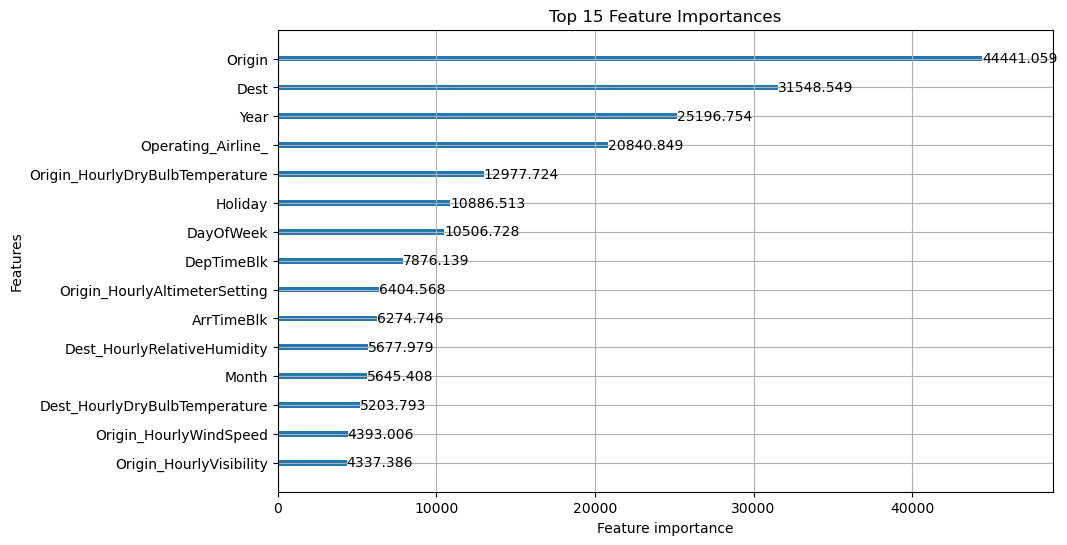

In [39]:
lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(10, 6))
plt.title("Top 15 Feature Importances")
plt.show()

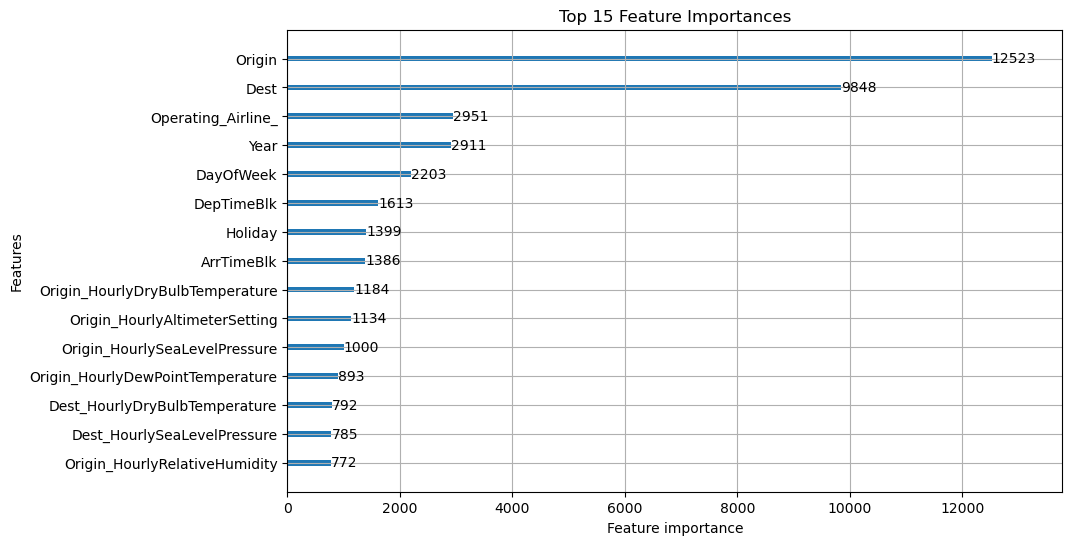

In [40]:
lgb.plot_importance(model, max_num_features=15, importance_type='split', figsize=(10, 6))
plt.title("Top 15 Feature Importances")
plt.show()

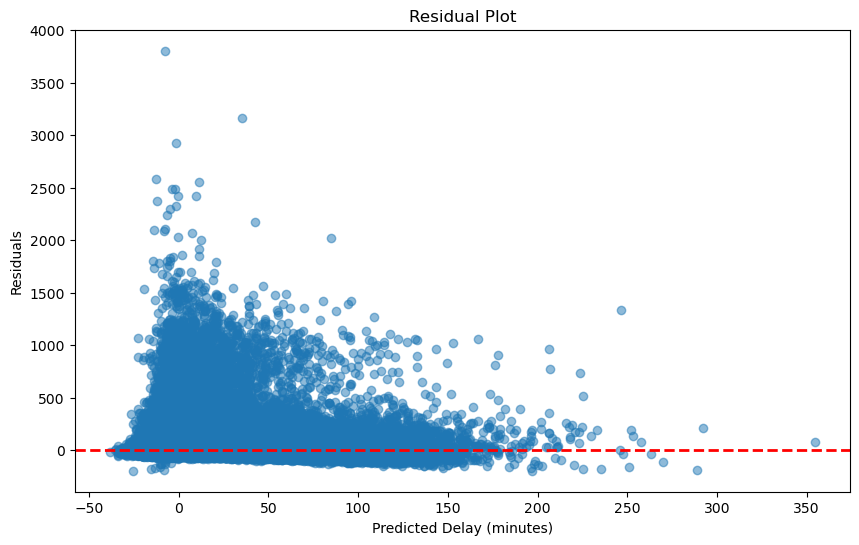

In [41]:
residuals = y_test_true - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Delay (minutes)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [45]:
from joblib import dump, load
import pandas as pd
from joblib import load
import numpy as np

# 保存模型
dump(model, "lightgbm_model.joblib")

# 保存 Booster 对象
model.booster_.save_model('lightgbm_model.txt')

['lightgbm_model.joblib']

### 从这里开始运行都可以！

In [35]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import vstack, csr_matrix
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import vstack, csr_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import make_scorer
from joblib import dump, load
import pandas as pd
from joblib import load
import numpy as np

data = pd.read_csv("final_data.csv")

data['Year']=data['Year'].astype('category')
data['Month']=data['Month'].astype('category')
data['DayOfWeek']=data['DayOfWeek'].astype('category')
data['Operating_Airline ']=data['Operating_Airline '].astype('category')
data['Origin']=data['Origin'].astype('category')
data['Dest']=data['Dest'].astype('category')
data['DepTimeBlk'] = data['DepTimeBlk'].astype('category')
data['ArrTimeBlk'] = data['ArrTimeBlk'].astype('category')
data['Origin_HourlyWindDirection'] = data['Origin_HourlyWindDirection'].astype('category')
data['Dest_HourlyWindDirection'] = data['Dest_HourlyWindDirection'].astype('category')
data['Holiday'] = data['Holiday'].astype('category')
data['Cancelled'] = data['Cancelled'].astype('category')
data = data.drop(columns=['ActualElapsedTime'])

continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns

data = data[data['Cancelled'] != 1]

min_arr_delay = data['ArrDelay'].min()
data = data[data['ArrDelay'] != min_arr_delay]

data = data.dropna(subset=['ArrDelay'])

min_delay = data["ArrDelay"].min() 
data['LogArrDelay'] = np.log1p(data["ArrDelay"] - min_delay +1)

X = data.drop(columns=['Cancelled', 'DepDelay', 'ArrDelay','LogArrDelay'])
y = data['LogArrDelay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns and convert them to category type if needed
categorical_features = X.select_dtypes(include=['category']).columns.tolist()
# Convert categorical columns in the train and test sets to categorical dtype for LightGBM
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    
# Set up LightGBM dataset with categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features, reference=train_data)

In [36]:
# 加载已训练好的 LightGBM 模型
model = load("lightgbm_model.joblib")

# 加载模型
booster = lgb.Booster(model_file='lightgbm_model.txt')

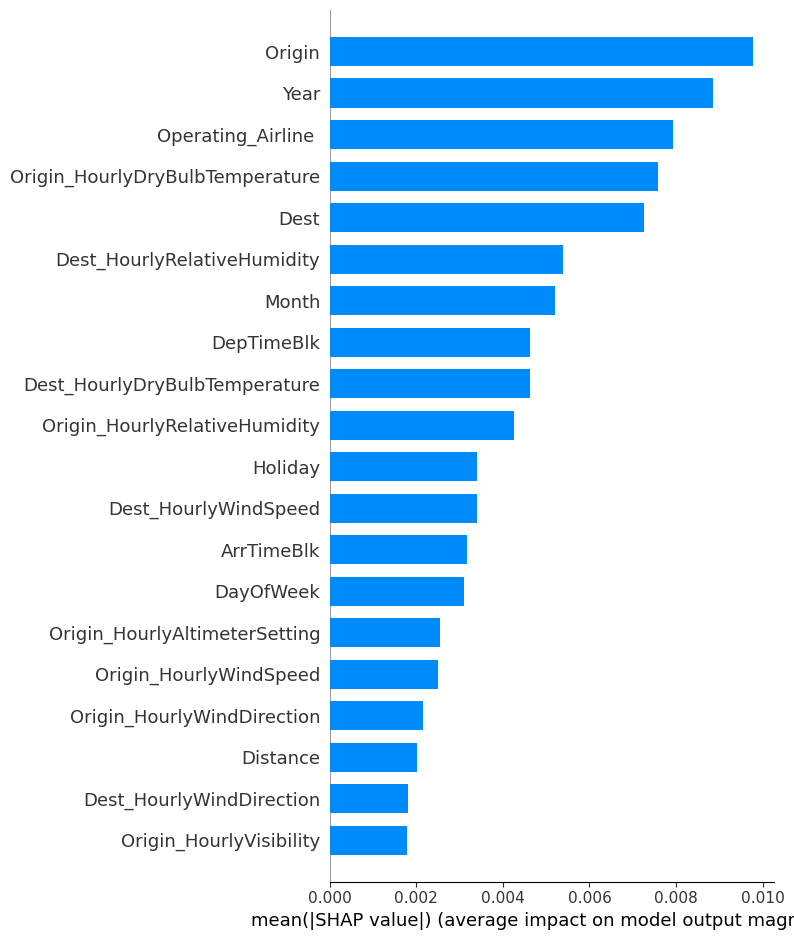

In [37]:
import shap

# 使用 SHAP 值解释模型
explainer = shap.TreeExplainer(model) 
sample_X = X.sample(n=10000, random_state=42)  # 抽样 10,000 个样本
shap_values = explainer.shap_values(sample_X)

# 绘制 SHAP Summary Plot，查看各个特征的类别如何影响预测
shap.summary_plot(shap_values, X, plot_type="bar")

In [49]:
# 获取 'Operating_Airline' 的 SHAP 值
origin_shap_values = pd.DataFrame({'Origin': sample_X['Origin'], 'SHAP Value': shap_values[:, X.columns.get_loc('Origin')]})

# 计算每个类别的平均正向和负向 SHAP 值
positive_mean_shap = origin_shap_values[origin_shap_values['SHAP Value'] > 0].groupby('Origin')['SHAP Value'].mean().sort_values(ascending=False)
negative_mean_shap = origin_shap_values[origin_shap_values['SHAP Value'] < 0].groupby('Origin')['SHAP Value'].mean().sort_values()

# 显示前几项（正向影响最大的类别和负向影响最大的类别）
print("Positive SHAP Values (Top 5):")
print(positive_mean_shap.head(5))

print("\nNegative SHAP Values (Top 5):")
print(negative_mean_shap.head(5))

Positive SHAP Values (Top 5):
Origin
MQT    0.043168
RDM    0.027766
DSM    0.027754
HDN    0.022080
SBP    0.021310
Name: SHAP Value, dtype: float64

Negative SHAP Values (Top 5):
Origin
BGR   -0.042139
CIU   -0.038619
ELM   -0.035179
RST   -0.032907
BRW   -0.032467
Name: SHAP Value, dtype: float64


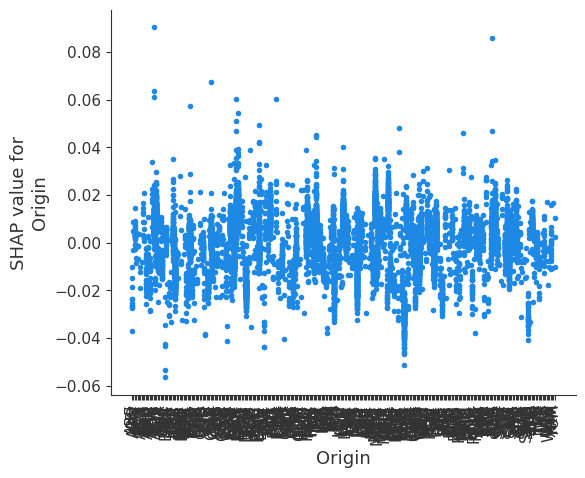

In [38]:
# 生成单个特征的 SHAP 值分布图，查看类别特征中每个类别的影响
shap.dependence_plot("Origin", shap_values, sample_X, interaction_index=None)

In [48]:
# 获取 'Operating_Airline' 的 SHAP 值
origin_shap_values = pd.DataFrame({'Operating_Airline ': sample_X['Operating_Airline '], 'SHAP Value': shap_values[:, X.columns.get_loc('Operating_Airline ')]})

# 计算每个类别的平均正向和负向 SHAP 值
positive_mean_shap = origin_shap_values[origin_shap_values['SHAP Value'] > 0].groupby('Operating_Airline ')['SHAP Value'].mean().sort_values(ascending=False)
negative_mean_shap = origin_shap_values[origin_shap_values['SHAP Value'] < 0].groupby('Operating_Airline ')['SHAP Value'].mean().sort_values()

# 显示前几项（正向影响最大的类别和负向影响最大的类别）
print("Positive SHAP Values (Top 5):")
print(positive_mean_shap.head(5))

print("\nNegative SHAP Values (Top 5):")
print(negative_mean_shap.head(5))


Positive SHAP Values (Top 5):
Operating_Airline 
B6    0.022698
AX    0.022688
G4    0.021060
C5    0.019655
EM    0.019382
Name: SHAP Value, dtype: float64

Negative SHAP Values (Top 5):
Operating_Airline 
YX   -0.017573
9E   -0.015772
DL   -0.010882
VX   -0.009263
UA   -0.006363
Name: SHAP Value, dtype: float64


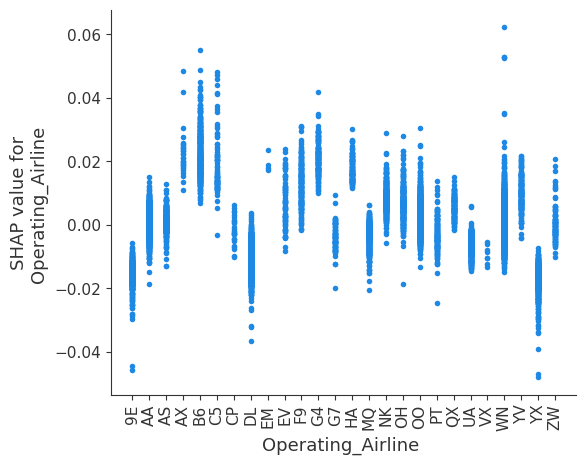

In [43]:
# 生成单个特征的 SHAP 值分布图，查看类别特征中每个类别的影响
shap.dependence_plot('Operating_Airline ', shap_values, sample_X, interaction_index=None)

from sklearn.inspection import permutation_importance

/# 计算排列重要性
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

/# 打印特征的重要性
for i in result.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]:<8} Importance: {result.importances_mean[i]:.3f}")

In [62]:
X.head(3)

,Year,Month,DayOfWeek,Operating_Airline,Origin,Dest,DepTimeBlk,ArrTimeBlk,Distance,Origin_HourlyAltimeterSetting,...,Dest_HourlyDewPointTemperature,Dest_HourlyDryBulbTemperature,Dest_HourlyPrecipitation,Dest_HourlyRelativeHumidity,Dest_HourlySeaLevelPressure,Dest_HourlyVisibility,Dest_HourlyWindDirection,Dest_HourlyWindGustSpeed,Dest_HourlyWindSpeed,Holiday
0,2018,1,1,EV,ATL,ABE,1500-1559,1700-1759,692,1032.8,...,-17.2,-11.7,0.0,64.0,1029.3,16.093,230-270,0.0,3.1,Around Newyear
1,2018,1,2,EV,ATL,ABE,1500-1559,1700-1759,692,1028.1,...,-16.7,-10.6,0.0,61.0,1027.9,16.093,230-270,0.0,3.1,Around Newyear
2,2018,1,3,EV,ATL,ABE,1000-1059,1200-1259,692,1017.6,...,-16.7,-4.4,0.0,38.0,1021.5,16.093,0-40,0.0,1.5,After Newyear


In [81]:
# 创建示例数据（包含缺失值）,确保输入的列别型数据
data1 = pd.read_excel("sampledata.xlsx")

for col in categorical_features:
    data1[col] = data1[col].astype('category')


data1['Year'] = data1['Year'].astype('Int64').astype('category')
data1['Month']=data1['Month'].astype('category')
data1['DayOfWeek']=data1['DayOfWeek'].astype('category')
data1['Operating_Airline ']=data1['Operating_Airline '].astype('category')
data1['Origin']=data1['Origin'].astype('category')
data1['Dest']=data1['Dest'].astype('category')
data1['DepTimeBlk'] = data1['DepTimeBlk'].astype('category')
data1['ArrTimeBlk'] = data1['ArrTimeBlk'].astype('category')
data1['Origin_HourlyWindDirection'] = data1['Origin_HourlyWindDirection'].astype('category')
data1['Dest_HourlyWindDirection'] = data1['Dest_HourlyWindDirection'].astype('category')
data1['Holiday'] = data1['Holiday'].astype('category')

data1

,Year,Month,DayOfWeek,Operating_Airline,Origin,Dest,DepTimeBlk,ArrTimeBlk,Distance,Origin_HourlyAltimeterSetting,...,Dest_HourlyDewPointTemperature,Dest_HourlyDryBulbTemperature,Dest_HourlyPrecipitation,Dest_HourlyRelativeHumidity,Dest_HourlySeaLevelPressure,Dest_HourlyVisibility,Dest_HourlyWindDirection,Dest_HourlyWindGustSpeed,Dest_HourlyWindSpeed,Holiday
0,2018,1,1,EV,ATL,ABE,1500-1559,1700-1759,692,1032.8,...,-17.2,-11.7,0.0,64.0,1029.3,16.093,230-270,0.0,3.1,Around Newyear
1,NaN,1,2,EV,ATL,ABE,1500-1559,1700-1759,692,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Around Newyear


In [83]:
first_row = data1.iloc[[0]]
model.predict(first_row)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


array([5.62386767])

In [85]:
nan_row = data1.iloc[[1]]
model.predict(nan_row)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


array([5.68787873])

In [86]:
# 创建示例数据（包含缺失值）
sample_data = pd.read_excel("sampledata.xlsx")
for col in categorical_features:
    sample_data[col] = sample_data[col].astype('category')

prediction = model.predict(sample_data)

# 输出预测结果
print("Prediction for the input data:", prediction)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
Prediction for the input data: [5.62386767 5.68787873]


### one hot

data = pd.read_csv("final_data.csv")
data['Year']=data['Year'].astype('category')
data['Month']=data['Month'].astype('category')
data['DayOfWeek']=data['DayOfWeek'].astype('category')
data['Operating_Airline ']=data['Operating_Airline '].astype('category')
data['Origin']=data['Origin'].astype('category')
data['Dest']=data['Dest'].astype('category')
data['DepTimeBlk'] = data['DepTimeBlk'].astype('category')
data['ArrTimeBlk'] = data['ArrTimeBlk'].astype('category')
data['Origin_HourlyWindDirection'] = data['Origin_HourlyWindDirection'].astype('category')
data['Dest_HourlyWindDirection'] = data['Dest_HourlyWindDirection'].astype('category')
data['Holiday'] = data['Holiday'].astype('category')
data['Cancelled'] = data['Cancelled'].astype('category')
data = data.drop(columns=['ActualElapsedTime'])

continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns

data = data[data['Cancelled'] != 1]
min_arr_delay = data['ArrDelay'].min()
data = data[data['ArrDelay'] != min_arr_delay]  # Remove row with minimum ArrDelay
data = data.dropna(subset=['ArrDelay'])

#log
min_delay = data["ArrDelay"].min() 
data['LogArrDelay'] = np.log1p(data["ArrDelay"] - min_delay +1)

X = data.drop(columns=['Cancelled', 'DepDelay', 'ArrDelay','LogArrDelay'])
y = data['LogArrDelay']

categorical_features = X.select_dtypes(include=['category']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  
)
preprocessor.fit(X) 

from scipy.sparse import vstack, csr_matrix

chunk_size = 500000  
X_transformed = csr_matrix((0, len(preprocessor.transform(X.iloc[:1]).toarray()[0])))

for start_row in range(0, len(X), chunk_size):
    end_row = min(start_row + chunk_size, len(X))
    data_chunk = X.iloc[start_row:end_row]  

    X_transformed_chunk = preprocessor.transform(data_chunk)

    print(f"Chunk shape: {X_transformed_chunk.shape}")

    X_transformed = vstack([X_transformed, X_transformed_chunk])

print(f"Transformed data shape: {X_transformed.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=123)

categories = preprocessor.transformers_[0][1].categories_

encoded_feature_names = []
for feature, category in zip(categorical_features, categories):
    encoded_feature_names.extend([f"{feature}_{cat}" for cat in category])

numerical_feature_names_org = preprocessor.transformers_[1][2] if len(preprocessor.transformers_) > 1 else []
numerical_feature_names = []

for index in numerical_feature_names_org:
    if isinstance(index, int) and index < len(data.columns):
        numerical_feature_names.append(data.columns[index])
    else:
        numerical_feature_names.append(index)

all_feature_names = encoded_feature_names + numerical_feature_names

def custom_huber_loss_objective(y_true, y_pred, delta=1.0):
    residual = y_true - y_pred
    abs_residual = np.abs(residual)
    is_small_error = abs_residual <= delta
    grad = np.where(is_small_error, residual, delta * np.sign(residual))
    hess = np.where(is_small_error, 1.0, 0.0)
    return grad, hess


params = {
    'learning_rate': 0.05,
    'max_depth': 10,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'n_estimators': 1000
}
delta = 1.0  

model = lgb.LGBMRegressor(
    **params,
    objective=lambda y_true, y_pred: custom_huber_loss_objective(y_true, y_pred, delta),
    random_state=42
)

model.fit(X_train, y_train)

y_train_log_pred = model.predict(X_train)
y_test_log_pred = model.predict(X_test)


y_train_pred = np.exp(y_train_log_pred) - 1 + min_delay
y_test_pred = np.exp(y_test_log_pred) - 1 + min_delay
y_train_true = np.exp(y_train) - 1 + min_delay
y_test_true = np.exp(y_test) - 1 + min_delay

train_mse = mean_squared_error(y_train_true, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_true, y_train_pred)
train_r2 = r2_score(y_train_true, y_train_pred)

test_mse = mean_squared_error(y_test_true, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_r2 = r2_score(y_test_true, y_test_pred)